In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
user = pd.read_csv('user_table.csv')
test_results = pd.read_csv('test_results.csv')

# Data preprocessing and EDA

In [4]:
# compile two available datasets
data = test_results.merge(user, how='left', on='user_id')
# convert the column timestamp to datetime object
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.strptime(x[:-9], '%Y-%m-%d'))

In [5]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


**There are some discrepancies in the dataset. A small proportion of users were charged at 39 dollars but labeled as the test group and users paid for 59 dollars were under the control group. Since it is uncertain whether these data points were typo or real mistakes and the size of it is relatively small, we can remove it from the main dataset.**

In [6]:
data.groupby(['test', 'price']).agg({"user_id": 'count'})

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [7]:
data = data[((data.price==39)&(data.test==0))|((data.price==59)&(data.test==1))]

# Question One

## Analysis

In [8]:
grouping = data.groupby(['test', 'price']).agg({"user_id": 'count', "converted":sum})
grouping['conversion_rate'] = grouping['converted']/grouping['user_id']
grouping

,,user_id,converted,conversion_rate
test,price,,,
0,39,202517,4030,0.019900
1,59,113918,1772,0.015555


**Since the samples of two groups are independent of each other, and it is fair to assume both population follow a binomial distribution, we can conduct a two sample Z proportion hypothesis test to verify if the conversion rate of the 39 dollars offer is better than the 59 dollars one.**

**The statistics for this test is $Z=\frac{\hat P_1- \hat P_2 - 0}{\sqrt{P_0(1-P_0)(\frac{1}{n_1} + \frac{1}{n_2}})}$, where $P_0$, $P_1$ and $P_2$ stands for the average conversion rate for all users, control group and test group, respectively.**

**In this case $P_0=(4030+1772)/(202517+113918)=0.01834, P_1=0.0199, P_2=0.01556, n_1=202517, n_2=113918$**

In [9]:
p0 = 0.01834
p1 = 0.0199
p2 = 0.01556
n1 = 202517
n2 = 113918

## Statistical Hypothesis

**The Z statistics for null hypothesis that the control group has the same conversion rate as the test group is 8.73, which is higher than the critical value of 1.96 at 5% of confidence level. Therefore, the null hypothesis is rejected, there has significant statistical evidence that those two groups have differnet conversion rate.**

In [10]:
Z = (p1 - p2)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
print("Z statistics is :", Z)

Z statistics is : 8.733617711378491


**The Z statistics is still greater than the threshold value at a difference of 0.003 but not for 0.004, which means we can not reject the claim that the control group was 0.3% better than the test group, statistically, but not 0.4% better.**

In [11]:
Z = (p1 - p2 - 0.003)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
print("Z statistics is :", Z)

Z statistics is : 2.696554777245896


In [12]:
Z = (p1 - p2 - 0.004)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
print("Z statistics is :", Z)

Z statistics is : 0.6842004658683642


## Conclusion

**Although the 39 dollars offer had a significant better conversion rate (0.3%) than the 59 dollars offer, the company should sell their software at 59 dollars. Because the revenue from the 39 dollars prcing was not more than the 59 dollars one. Since 39 is about one third (34%) less than 59, which means if the conversion rate of the 39 dollars pricing does not exceed its counterpart by one third (34%), the overall revenue would be less, instead. In fact, the conversion rate of the 39 pricing is only 16% (0.003/0.01834) better than the 59 one. Thus, the 59 dollars pricing is prefered, simply from the financial perspective.**

# Question two

## Analysis

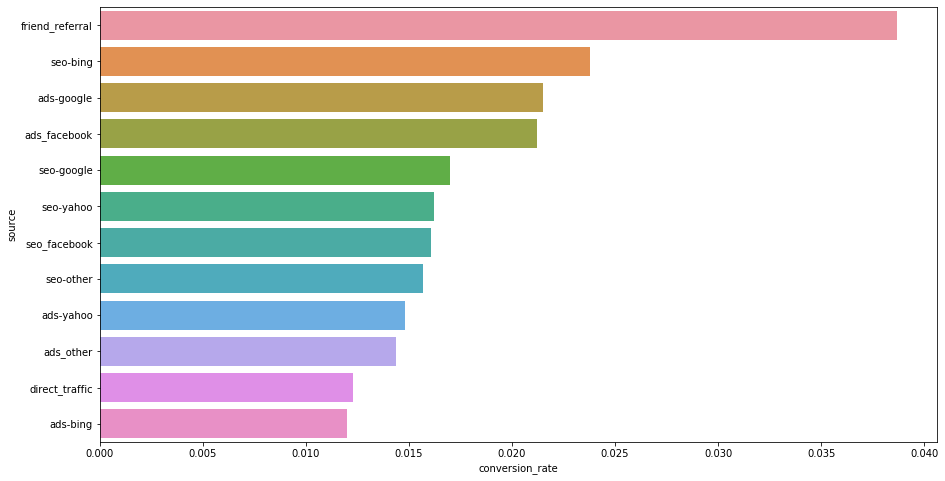

In [13]:
group_source = data.groupby(['source'], as_index=False).agg({"user_id": 'count', "converted": sum})
group_source['conversion_rate'] = group_source['converted']/group_source['user_id']
group_source = group_source.sort_values('conversion_rate', ascending=False)
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=group_source, x='conversion_rate', y='source', orient='h');

In [14]:
group_device = data.groupby('device', as_index=False).agg({"user_id": 'count', "converted": sum})
group_device['conversion_rate'] = group_source['converted']/group_source['user_id']
group_device

,device,user_id,converted,conversion_rate
0,mobile,186267,3456,0.012001
1,web,130168,2346,0.021502


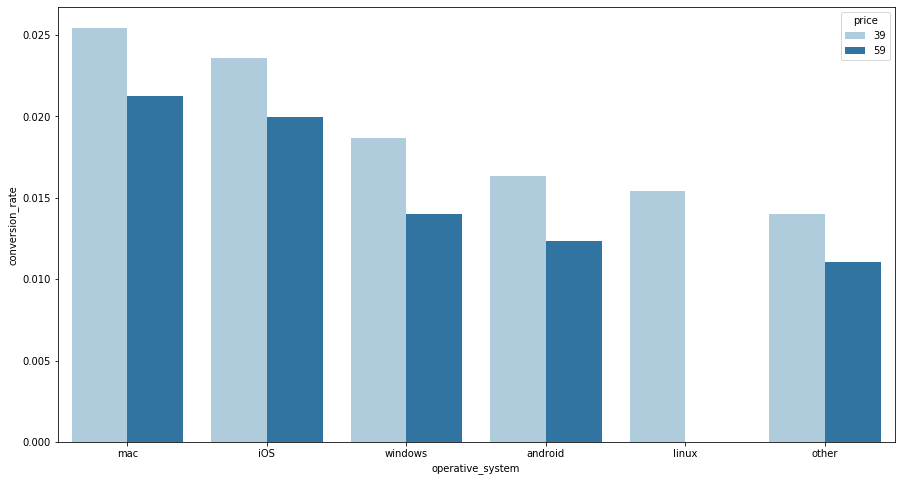

In [15]:
group_os = data.groupby(['operative_system', 'price'], as_index=False).agg({"user_id": 'count', "converted": sum})
group_os['conversion_rate'] = group_os['converted']/group_os['user_id']
group_os = group_os.sort_values('conversion_rate', ascending=False)
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=group_os, x='operative_system', y='conversion_rate', palette='Paired', hue='price');

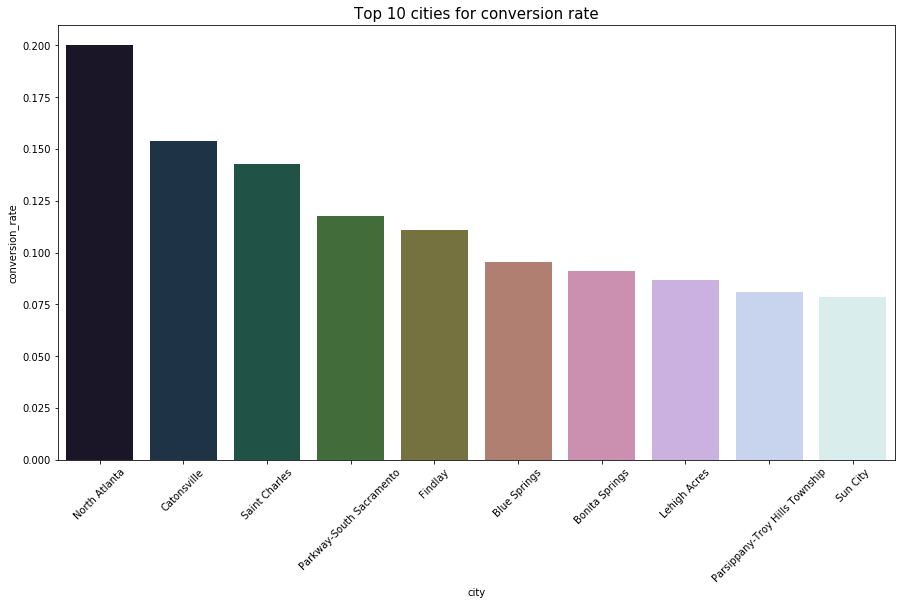

In [16]:
group_city = data.groupby('city', as_index=False).agg({"user_id": 'count', "converted": sum})
group_city['conversion_rate'] = group_city['converted']/group_city['user_id']
group_city = group_city.sort_values('conversion_rate', ascending=False)
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=group_city[:10], x='city', y='conversion_rate', palette='cubehelix')
plt.xticks(rotation=45)
plt.title("Top 10 cities for conversion rate", fontsize=15);

## Conclusion

- **Among all sources, friend referal was the most effective way followed by seo-bing and ads-google. The conversion rate for this source was so outstanding that worth to put extra resources in it.**
- **Mac and IOS users converted the most compare to other operating systems. A targed marketing or investigation is in need to dig more value out of it.**
- **Users on linux operating system seemed to lack interest in the software, especially when the pricing was high. Investigation needed to be done to find out reasons.**